<a href="https://colab.research.google.com/github/cu-applied-math/SciML-Class/blob/lab_solutions/Labs/lab04_AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Experimenting with automatic differentiation

Some of this inspired by [A mathematical model for automatic differentiation
in machine learning](https://hal.science/hal-02734446/file/finalVersion.pdf) by Jerome Bolte and Edouard Pauwels, NeurIPS 2020

PyTorch info
- https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
- [Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html) PyTorch doc has all the details, including:
  - [Gradients for non-differentiable functions](https://pytorch.org/docs/stable/notes/autograd.html#gradients-for-non-differentiable-functions)

Lab by Stephen Becker, SciML class at CU Boulder

In [1]:
import torch
from matplotlib import pyplot as plt
from time import time
import torch.utils.benchmark as benchmark
import numpy as np

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


## Task 1: explore three implementations of ReLU
We'll explore via experimentation.  We first define the $r$ to be the usual ReLU,
$$r(x) = \begin{cases} 0 & x \le 0 \\ x & x > 0\end{cases}
$$
(though note that if we change the $x\le 0$ vs $x>0$ to be $x < 0$ vs $x \ge 0$, that would potentially change things!)

Then define two variant **implementations**,
$$ r_2(x) = r(-x) + x, \quad r_3(x) = \frac12\Big( r(x) + r_2(x) \Big).$$
These should be the same mathematical function as the original ReLU, just via different implmentations.

For each of the three implementations, plot the value of the derivative that PyTorch's autodiff gives you for the x values $\{-1,-.75,-.5,-.25,0,.25,.5,.75,1\}$

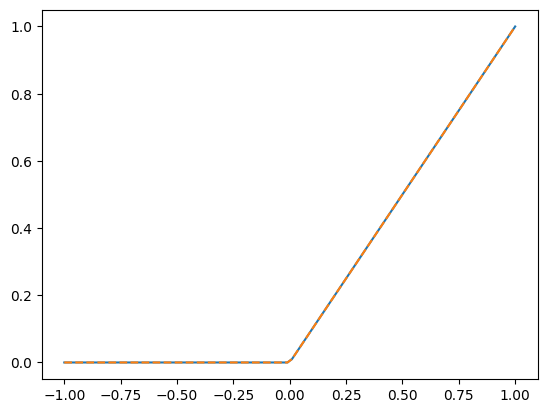

In [2]:
# def myReLU_scalar(x):
#     if x <= 0:
#         return 0
#     else:
#         return x

# If we want to work on vectors/matrices/tensors, we can use torch.vmap
# https://pytorch.org/tutorials/prototype/vmap_recipe.html
# Nevermind, it doesn't work with control flow (like "if" statements)
# myReLU = torch.vmap( myReLU_scalar )
# myReLU = myReLU_scalar
myReLU  = torch.relu

myReLU2 = lambda x : myReLU(-x) + x
myReLU3 = lambda x : (myReLU(x) + myReLU2(x))/2

xGrid = torch.linspace(-1,1,100)
plt.plot( xGrid, [myReLU(x) for x in xGrid], '-',label='ReLU ver. 1' )
plt.plot( xGrid, [myReLU2(x) for x in xGrid], '--', label='ReLU ver. 2' )
plt.show()

#### Find some derivatives

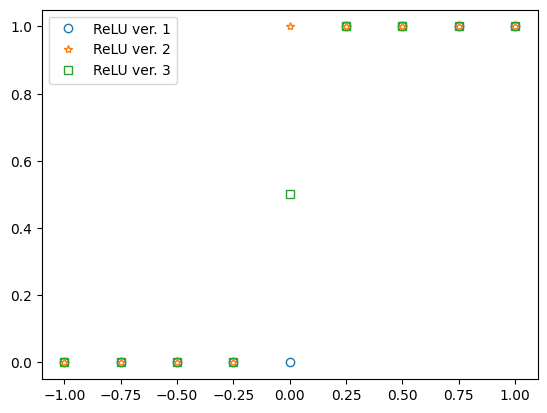

In [3]:
def find_derivative(fcn,xGrid):
    x      = torch.zeros(1, requires_grad = True)
    deriv = torch.zeros_like(xGrid)
    for i,xval in enumerate(xGrid):
        x.data = xval
        fx = fcn(x)
        fx.backward()
        deriv[i] = x.grad.data
        x.grad.data.zero_()
    return deriv

xGrid  = torch.Tensor( [-1.,-.75,-.5,-.25,0,.25,.5,.75,1.])
deriv1 = find_derivative(myReLU, xGrid)
deriv2 = find_derivative(myReLU2, xGrid)
deriv3 = find_derivative(myReLU3, xGrid)

plt.plot( xGrid.numpy(), deriv1.numpy(),'o', label = 'ReLU ver. 1', fillstyle='none')
plt.plot( xGrid.numpy(), deriv2.numpy(), '*',label = 'ReLU ver. 2', fillstyle='none')
plt.plot( xGrid.numpy(), deriv3.numpy(), 's',label = 'ReLU ver. 3', fillstyle='none')
plt.legend()
plt.show()

## Task 2: make the sine function but with funny derivative
Your task is to define a function $f$ in Python that is mathematically equivalent to $\sin(x)$, but such that when you do AD on your implementation, the returned derivative is
$$f'(x) = \begin{cases} \cos(x) & x \neq \frac12 \\ 3.8 & x = \frac12\end{cases}$$

For credit for the lab, turn in a PDF (upload to Canvas) showing your Python code and a plot of the derivative.  

*When you plot your derivative, if you use `torch.linspace` or similar to make the $x$ values, be sure to include the point $x=\frac12$*

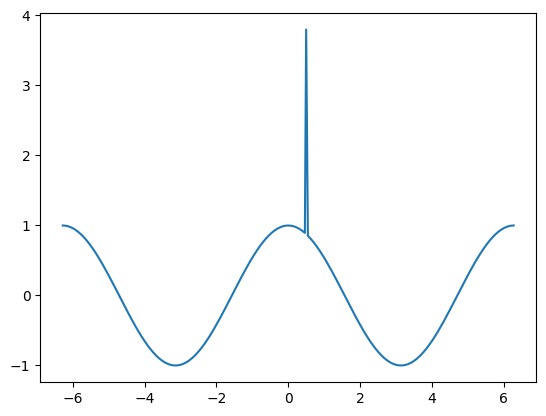

In [4]:
f = torch.sin
def funny_zero(x):
    return myReLU2(x) - myReLU(x)

# funny_points = torch.Tensor( [-.5, .2, .6 ])
funny_points = torch.Tensor( [.5 ])
def funny_sin(x):
    y = f(x) # regular sin
    for pt in funny_points:
        y += (3.8-np.cos(.5))*funny_zero( x - pt )  # add zero
    return y

xGrid  = torch.linspace(-2*np.pi,2*np.pi,150)
xGrid  = torch.cat( (xGrid,funny_points)).unique()
deriv  = find_derivative(funny_sin, xGrid)
plt.plot( xGrid.numpy(), deriv.numpy() )
plt.show()

## Bonus 1
Below is an example of the function $f(x)=0$, but we calculate it in a very slow way.

By timing the autodiff, we can see that the backpropagation calculation faithfully backpropagates through our silly calculation. This just emphasizes that AD depends on your **implementation**

In [5]:
d   = int(4e3)

torch.manual_seed(100)
A   = torch.randn( (d,d) )

def f(x, N = 100):
    """ Implements the zero function: f(x) = 0 """
    for k in range(N):
        x = A @ x

    return torch.sum(x - x)

x   = torch.randn( (d,1), requires_grad=True )

# https://pytorch.org/tutorials/recipes/recipes/benchmark.html
# The fancy way to do it...
# t = benchmark.Timer(
#     stmt='f(x)',
#     setup='from __main__ import f',
#     globals={'x':x}
# )
# nRuns = 5
# print(t.timeit(nRuns))

# The quick-and-dirty way to time:
with torch.no_grad():
    tStart = time()
    f(x)
    tEnd   = time()
    print(f'Elapsed time to evaluate f(x) is {tEnd-tStart:.3f} seconds')

# Let's ask for the derivative
tStart = time()
fx = f(x)  # this will take longer than before, since it will do the forward accumulation
fx.backward()
#x.grad
tEnd   = time()
print(f'Elapsed time to evaluate the gradient is {tEnd-tStart:.3f} seconds')
x.grad.data.zero_()

print('Done')

Elapsed time to evaluate f(x) is 0.926 seconds
Elapsed time to evaluate the gradient is 2.136 seconds
Done


## Bonus 2: Calculating gradients without crashing the computer
Let $Y\in\mathbb{R}^{n\times n}$ be a symmetric matrix, and let $U\in\mathbb{R}^{n\times r}$ for some $r\le n$. We're interested in the function
$$f(U) = \frac12\|UU^\top - Y\|_F^2.$$

If $n \gtrapprox 30,000$ then it's getting hard to store a dense matrix $Y$ of that size on a laptop.  Let's say we have a **sparse** matrix $Y$.


For this lab, let $n=100,000$ and $r=5$.

- Can you compute $f(U)$ without crashing the computer?
- Can you compute $\nabla f$ without crashing the computer?
- Can you use PyTorch autodiff to give you the gradient in a reasonable amount of time or memory?

In [6]:
import scipy.sparse
from scipy.sparse.linalg import norm as sparseNorm
from torch import norm
from time import time

In [7]:
m = int(1e5)
m = int(1e4)
n = m
r = 5
SMALL_PROBLEM = n <= 1e3

if SMALL_PROBLEM:
    density = 0.03 # for debugging
else:
    density = 0.0001

rng = np.random.default_rng(123) # seed it for reproducibility
Y   = scipy.sparse.random_array( (m,n), density=density, random_state=rng)
Y   = Y@Y.T # make it symmetric (and psd)), CSR format by default

# Convert it to a torch tensor
Ytorch = torch.sparse_csr_tensor( Y.indptr, Y.indices, Y.data, size=(n,n) )
if SMALL_PROBLEM:
    print(f'Error between scipy and torch is {norm( Ytorch.to_dense() - Y.toarray() ):.2e}')

<ipython-input-7-51ae4e0f2e09>:17: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  Ytorch = torch.sparse_csr_tensor( Y.indptr, Y.indices, Y.data, size=(n,n) )


In [8]:
def f_naive(U):
    return norm( U@U.T - Ytorch.to_dense() )**2/2

nrmY2 = scipy.sparse.linalg.norm(Y)**2
def f(U, grad=False ):
    YU  = Ytorch@U
    UtU = U.T@U
    f   = norm(UtU)**2/2 + nrmY2/2 - torch.dot( U.ravel(), YU.ravel() )
    if grad:
        # Gradient is requested
        g = 2*( U@UtU - YU )
        return f, g
    else:
        return f
torch.manual_seed(42)
U   = torch.randn( (n,r), dtype = torch.double, requires_grad=True  )

# if SMALL_PROBLEM:
print( f_naive(U).item() )
print( f(U).item() )

start_time = time()
f1,g1 = f(U,grad=True)
e_time = time() - start_time
print(f'Took {e_time} seconds (by hand)')

# Use autodiff
start_time = time()
f0 = f_naive(U)
f0.backward()
g0 = U.grad     # U.grad.data.zero_() if needed
e_time = time() - start_time
print(f'Took {e_time} seconds (via PyTorch AD)')
print(f'Discrepancy: {norm( g0 - g1 ).item():.2e}')

253569955.43842122
253569955.43843094
Took 0.004783153533935547 seconds (by hand)
Took 8.236544847488403 seconds (via PyTorch AD)
Discrepancy: 1.44e-09
